In [62]:
pip freeze > model_requirements.txt    

Note: you may need to restart the kernel to use updated packages.


In [63]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
data_train_df = pd.read_csv("data_train_csv")
data_smauto_train_df = pd.read_csv("data_smauto_train_csv")
data_smin_train_df = pd.read_csv("data_smin_train_csv")

data_test_df = pd.read_csv("data_test_csv")
data_val_df = pd.read_csv("data_val_csv")

In [65]:
print(f'Data_train: {data_train_df.shape}, Data smauto: {data_smauto_train_df.shape}, Data smin: {data_smin_train_df.shape}')

Data_train: (198047, 9), Data smauto: (301677, 9), Data smin: (296133, 9)


In [66]:
#own module which takes in df for train, test and val and returns in x and y format.  Can also sample.
from data_formatting import data_format

In [67]:
print(data_train_df['Winner_num'].value_counts())
print(data_smauto_train_df['Winner_num'].value_counts())
print(data_smin_train_df['Winner_num'].value_counts())

Winner_num
0    100559
2     95015
1      2473
Name: count, dtype: int64
Winner_num
0    100559
2    100559
1    100559
Name: count, dtype: int64
Winner_num
0    100559
1    100559
2     95015
Name: count, dtype: int64


Random Forest model

Train the baseline RF classifier

In [68]:
def rf(train_data, test_data, val_data, sample, proportion):
    #own module which takes in df for train, test and val and returns in x and y format.  Can also sample.
    from data_formatting import data_format
    X_train, X_test, X_val, y_train, y_test, y_val = data_format(train_data, test_data, val_data, sample, proportion)

    model = RandomForestClassifier(random_state=7)
    model.fit(X_train, y_train)

    model_train_score = model.score(X_train, y_train)
    model_test_score = model.score(X_test, y_test)
    print(f"Training score: {model_train_score}, Testing score: {model_test_score}" )

    y_pred = model.predict(X_test)

    labels = ['Team 1', 'Tie', 'Team 2']
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

    cmd.plot()
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    print(classification_report(y_test, y_pred, target_names=labels))

Training score: 0.9586764757860508, Testing score: 0.9077820171333957


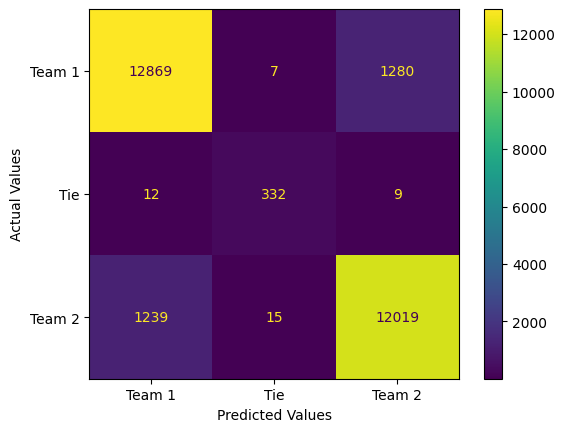

              precision    recall  f1-score   support

      Team 1       0.91      0.91      0.91     14156
         Tie       0.94      0.94      0.94       353
      Team 2       0.90      0.91      0.90     13273

    accuracy                           0.91     27782
   macro avg       0.92      0.92      0.92     27782
weighted avg       0.91      0.91      0.91     27782



In [69]:
rf(data_train_df, data_test_df, data_val_df, None, None)

Training score: 0.9728683326869466, Testing score: 0.9078540061910589


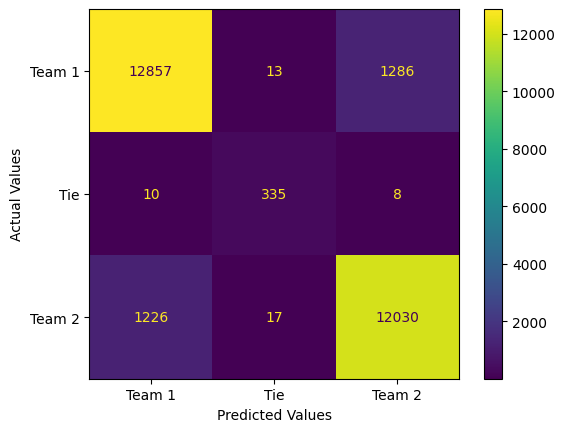

              precision    recall  f1-score   support

      Team 1       0.91      0.91      0.91     14156
         Tie       0.92      0.95      0.93       353
      Team 2       0.90      0.91      0.90     13273

    accuracy                           0.91     27782
   macro avg       0.91      0.92      0.92     27782
weighted avg       0.91      0.91      0.91     27782



In [70]:
rf(data_smauto_train_df, data_test_df, data_val_df, None, None)

Training score: 0.9723637689821804, Testing score: 0.9074220718450795


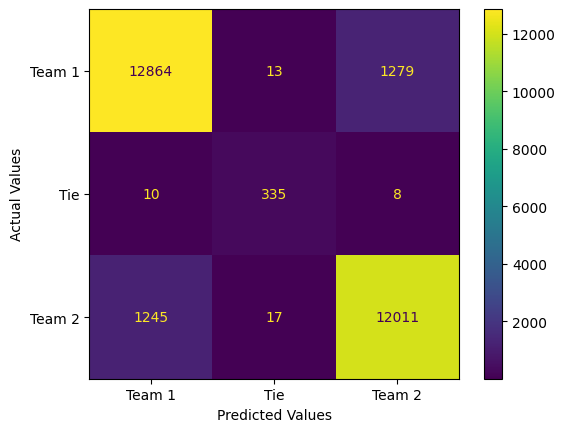

              precision    recall  f1-score   support

      Team 1       0.91      0.91      0.91     14156
         Tie       0.92      0.95      0.93       353
      Team 2       0.90      0.90      0.90     13273

    accuracy                           0.91     27782
   macro avg       0.91      0.92      0.92     27782
weighted avg       0.91      0.91      0.91     27782



In [71]:
rf(data_smin_train_df, data_test_df, data_val_df, None, None)

Using min because recall is the more importantmetric in this case. Recall is the number of true positives/ true positives + False negatives.  I.e. out of the number of times it was actually positive, how many times did we predict it to be so.  Not as much of a concern for false negatives in category 1 because it has less impact than incorrectly giving the win to another team.

<ins>**Tune the RF**</ins>

Because I'm using the full data, chosen to train on each parameter in turn and plot results.  In other models, chose to run the combinations but I used a sample of the data instead.

In [72]:
X_train, X_test, X_val, y_train, y_test, y_val = data_format(data_smin_train_df, data_test_df, data_val_df, None, None)

In [185]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8],
    'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_depth': [10, 30,50, 60, 70, 80, 90, 100]
    }

In [192]:
from sklearn.feature_selection import f_classif, SelectKBest
from itertools import product

# Create an empty dictionary to store the total ANOVA score for each hyperparameter
total_anova_scores = {hyperparameter: 0 for hyperparameter in param_grid}

# Create an empty array to store ANOVA scores for each hyperparameter
anova_scores = []

# Loop through all combinations of hyperparameter values
for hyperparameter_values in product(*param_grid.values()):
    hyperparameters = dict(zip(param_grid.keys(), hyperparameter_values))

    # Create a Random Forest model
    rf = RandomForestClassifier(random_state=7)

    # Create a feature selector using ANOVA
    selector = SelectKBest(f_classif, k='all')

    # Fit the selector on the training data with the specific hyperparameter values
    selector.fit(X_train, y_train)

    # Get the ANOVA scores for each feature
    anova_scores.extend(zip(hyperparameters, selector.scores_))

    # Accumulate the ANOVA scores for each hyperparameter
    for hyperparameter, score in zip(hyperparameters, selector.scores_):
        total_anova_scores[hyperparameter] += score 

# Sort hyperparameters based on their total scores in descending order
sorted_hyperparameters = sorted(total_anova_scores.items(), key=lambda x: x[1], reverse=True)

# Print the hyperparameters in order of highest total score to lowest
for hyperparameter, total_score in sorted_hyperparameters:
    print(f"{hyperparameter}: {total_score}")

max_features

1 max features, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9115598509799687
1 max features, Train Loss: 0.05193291105304984, Validation Accuracy: 0.2911308510825825
2 max features, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9115778485682918
2 max features, Train Loss: 0.04975303002246557, Validation Accuracy: 0.2930224450543053
3 max features, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.911703831686554
3 max features, Train Loss: 0.04904962779783921, Validation Accuracy: 0.2914598879770408
4 max features, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9116498389215845
4 max features, Train Loss: 0.04877231119622274, Validation Accuracy: 0.29775884407591585
5 max features, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9116138437449381
5 max features, Train Loss: 0.04870307250600871, Validation Accuracy: 0.29558772106220815
6 max features, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.911379875096737
6 m

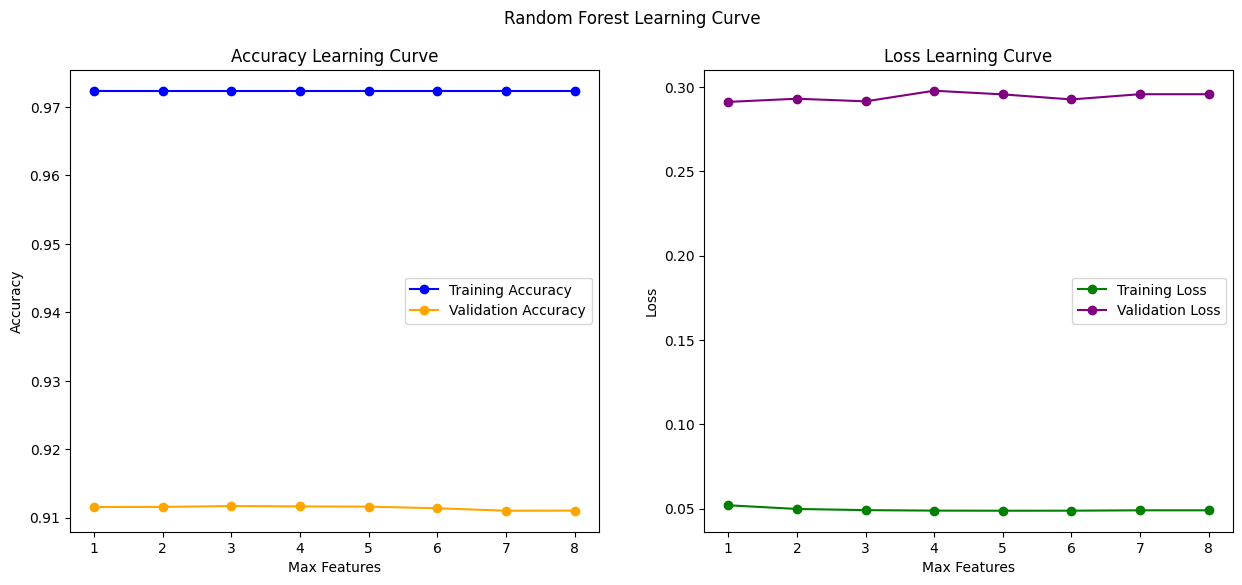

In [159]:
best_accuracy = 0
best_loss=100
maxfeatures_list = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for mf in range(1,9):
    maxfeatures_list.append(mf)

    model = RandomForestClassifier(max_features=mf,n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    
    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)

    print(f"{mf} max features, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{mf} max features, Train Loss: {train_loss}, Validation Accuracy: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_mf= mf

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_mf = mf

print(f"Best accuracy is: {best_accuracy} and max features is {best_acc_mf}")
print(f"Best accuracy is: {best_loss} and max features is {best_loss_mf}")

mf_acc_df = pd.DataFrame({'Max Features': maxfeatures_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
mf_loss_df = pd.DataFrame({'Max Features': maxfeatures_list,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.title('Accuracy Learning Curve')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.plot(mf_acc_df['Max Features'], mf_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(mf_acc_df['Max Features'], mf_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()


plt.subplot(122)
plt.title('Loss Learning Curve')
plt.xlabel('Max Features')
plt.ylabel('Loss')
plt.plot(mf_loss_df['Max Features'], mf_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(mf_loss_df['Max Features'], mf_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()
 
plt.suptitle("Random Forest Learning Curve")
plt.show()

n_estimators

1 n_estimators, Train Accuracy: 0.9646408877092387, Validation Accuracy: 0.9069164731925922
1 n_estimators, Train Loss: 0.7137268031101843, Validation Loss: 2.8358006008190633
51 n_estimators, Train Accuracy: 0.972343507815745, Validation Accuracy: 0.9108579450353652
51 n_estimators, Train Loss: 0.04927017911419595, Validation Loss: 0.3508837392268315
101 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9117398268632003
101 n_estimators, Train Loss: 0.04904141237827673, Validation Loss: 0.29136563718843245
151 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9122257617479258
151 n_estimators, Train Loss: 0.048972523205188905, Validation Loss: 0.2730010456645526
201 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9124057376311574
201 n_estimators, Train Loss: 0.04892866493363726, Validation Loss: 0.26521375390278645
251 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9125497183377428
251 n_

C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


451 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9130716483991145
451 n_estimators, Train Loss: 0.04889040975022243, Validation Loss: 0.25012748839680693
501 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9132876194589925
501 n_estimators, Train Loss: 0.04888862665173027, Validation Loss: 0.24896404742889722
551 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9130716483991145
551 n_estimators, Train Loss: 0.04888633017847032, Validation Loss: 0.24682197507838113


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


601 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.913233626694023
601 n_estimators, Train Loss: 0.04888374883082707, Validation Loss: 0.2458057488524991


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


651 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9131796339290535
651 n_estimators, Train Loss: 0.048879746334317624, Validation Loss: 0.24486063715734352


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


701 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9132516242823462
701 n_estimators, Train Loss: 0.04888013591170439, Validation Loss: 0.2447366444658793


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


751 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9133056170473156
751 n_estimators, Train Loss: 0.048878770476420745, Validation Loss: 0.24364427227817925


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


801 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9133056170473156
801 n_estimators, Train Loss: 0.048874424265349665, Validation Loss: 0.24265738262900172


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


851 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9132876194589925
851 n_estimators, Train Loss: 0.04887397116684062, Validation Loss: 0.24207470007180787
901 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9132696218706693
901 n_estimators, Train Loss: 0.048873493860870545, Validation Loss: 0.2420918264669248


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


951 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9133236146356388
951 n_estimators, Train Loss: 0.0488740003843125, Validation Loss: 0.24107528392145394


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1001 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9133776074006084
1001 n_estimators, Train Loss: 0.04887347322093104, Validation Loss: 0.24053552738392772


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1051 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9134855929305473
1051 n_estimators, Train Loss: 0.048870376340307255, Validation Loss: 0.2405418366731479


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1101 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9135755808721632
1101 n_estimators, Train Loss: 0.04886918589264237, Validation Loss: 0.24049300070969995


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1151 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9135215881071936
1151 n_estimators, Train Loss: 0.04886664004425046, Validation Loss: 0.24002123111426507


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1201 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9137015639904252
1201 n_estimators, Train Loss: 0.048864454835152685, Validation Loss: 0.2395437827450516


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1251 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9136295736371326
1251 n_estimators, Train Loss: 0.048860168464065955, Validation Loss: 0.23844776079277166


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1301 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9136475712254558
1301 n_estimators, Train Loss: 0.048861157499529136, Validation Loss: 0.23844088207785127


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1351 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9137015639904252
1351 n_estimators, Train Loss: 0.04886250396016678, Validation Loss: 0.23786370386223832


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1401 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9137195615787485
1401 n_estimators, Train Loss: 0.048863090788730294, Validation Loss: 0.23681294520863647


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1451 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9137195615787485
1451 n_estimators, Train Loss: 0.04886312345294345, Validation Loss: 0.23630048052301722


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1501 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9137555567553948
1501 n_estimators, Train Loss: 0.048862418201922254, Validation Loss: 0.2363482233252761


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1551 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9138275471086874
1551 n_estimators, Train Loss: 0.04886259153601359, Validation Loss: 0.23634242515596326


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1601 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9138095495203643
1601 n_estimators, Train Loss: 0.04886334101702176, Validation Loss: 0.23584618147501188


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1651 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9138095495203643
1651 n_estimators, Train Loss: 0.0488636151666842, Validation Loss: 0.23531569018860227


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1701 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9138635422853337
1701 n_estimators, Train Loss: 0.048862056098202884, Validation Loss: 0.23479101345725845


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1751 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9139355326386264
1751 n_estimators, Train Loss: 0.04886098182239339, Validation Loss: 0.23477552334998997


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1801 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9139175350503033
1801 n_estimators, Train Loss: 0.048859874617514676, Validation Loss: 0.2347949041721372


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1851 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.9139355326386264
1851 n_estimators, Train Loss: 0.04885948796616999, Validation Loss: 0.23480695390575265


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1901 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.91389953746198
1901 n_estimators, Train Loss: 0.048857940246530625, Validation Loss: 0.23432323333880156


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


1951 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.91389953746198
1951 n_estimators, Train Loss: 0.04885602551013527, Validation Loss: 0.2343290548300856


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


2001 n_estimators, Train Accuracy: 0.9723637689821804, Validation Accuracy: 0.913881539873657
2001 n_estimators, Train Loss: 0.0488560085157814, Validation Loss: 0.23432871039042105
Best accuracy is: 0.9139355326386264 and estimators is 1751
Best loss is: 0.23432323333880156 and estimators is 1901


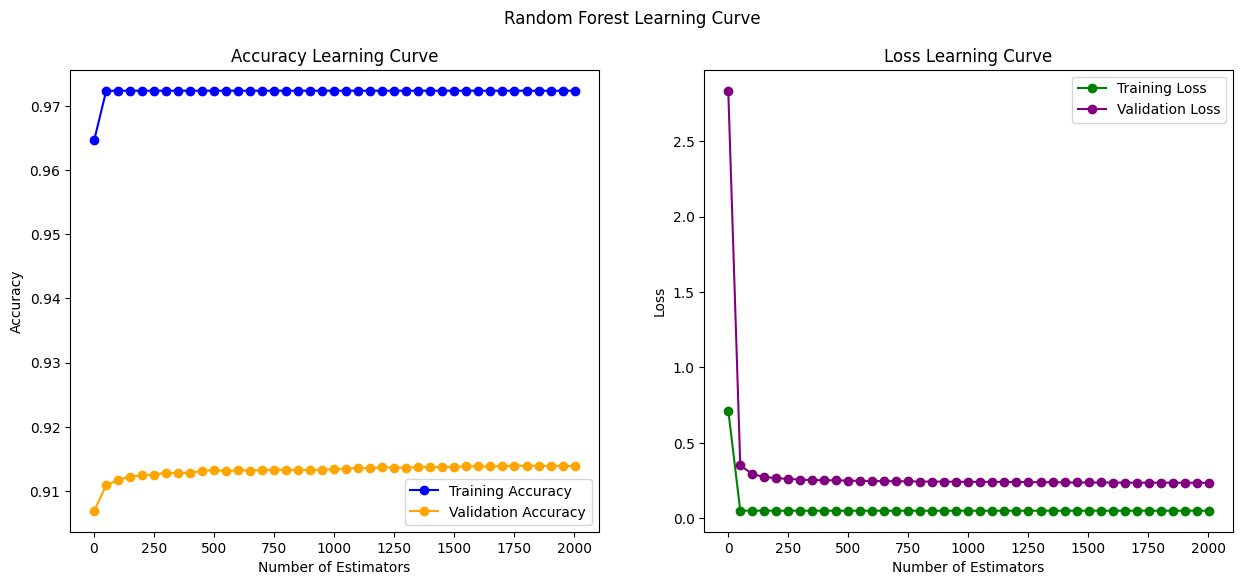

In [166]:
best_accuracy = 0
best_loss=100
estimators = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for e in range(1,2002, 50):
    estimators.append(e)

    model = RandomForestClassifier(max_features=3, n_estimators=e, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)

    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)


    print(f"{e} n_estimators, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{e} n_estimators, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_estimators = e

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_estimators = e
    
estimators_acc_df = pd.DataFrame({'Estimators': estimators,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
estimators_loss_df = pd.DataFrame({'Estimators': estimators,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})



print(f"Best accuracy is: {best_accuracy} and estimators is {best_acc_estimators}")
print(f"Best loss is: {best_loss} and estimators is {best_loss_estimators}")

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.title('Accuracy Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()

plt.subplot(122)
plt.title('Loss Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Loss')
plt.plot(estimators_loss_df['Estimators'], estimators_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(estimators_loss_df['Estimators'], estimators_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()

plt.suptitle("Random Forest Learning Curve")
plt.show()

1 n_estimators, Train Accuracy: 0.9646408877092387, Validation Accuracy: 0.9069164731925922
1 n_estimators, Train Loss: 0.7137268031101843, Validation Loss: 2.8358006008190633
2 n_estimators, Train Accuracy: 0.9658092816403441, Validation Accuracy: 0.9069524683692385
2 n_estimators, Train Loss: 0.20973189741688666, Validation Loss: 1.9077290027322085
3 n_estimators, Train Accuracy: 0.9694022618215464, Validation Accuracy: 0.9104440005039325
3 n_estimators, Train Loss: 0.09729787268114262, Validation Loss: 1.5545611017712477
4 n_estimators, Train Accuracy: 0.9698682686495594, Validation Accuracy: 0.910282022209024
4 n_estimators, Train Loss: 0.06782127483835072, Validation Loss: 1.3247515611143696
5 n_estimators, Train Accuracy: 0.970614554946595, Validation Accuracy: 0.9103000197973472
5 n_estimators, Train Loss: 0.057714660891740155, Validation Loss: 1.1441080425355319
6 n_estimators, Train Accuracy: 0.9708104128888033, Validation Accuracy: 0.9101920342674081
6 n_estimators, Train Los

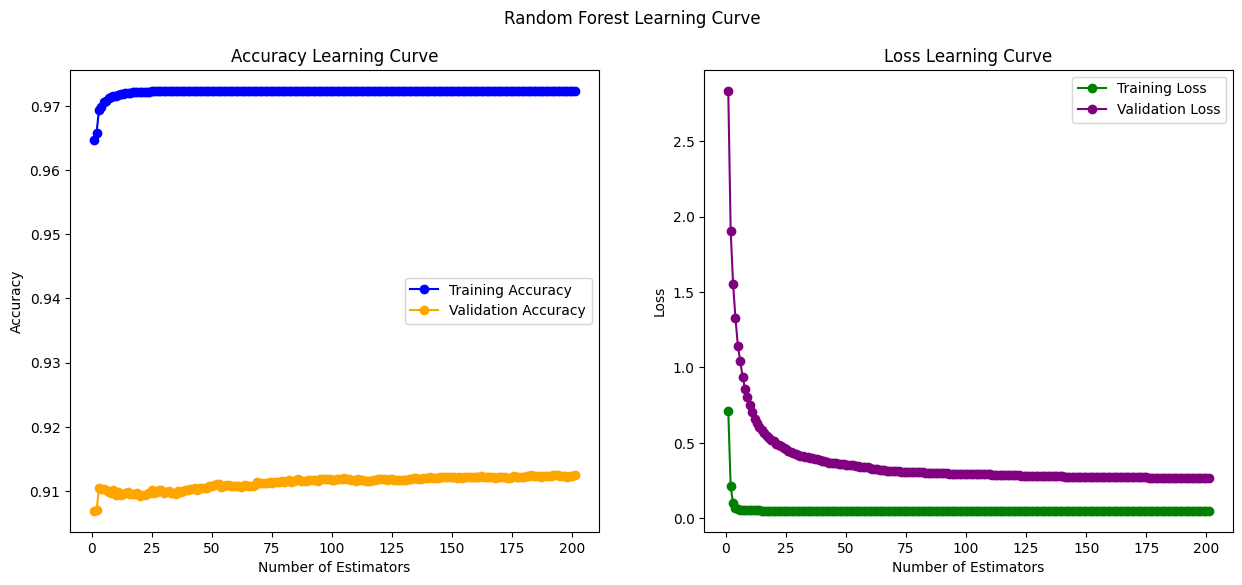

In [170]:
best_accuracy = 0
best_loss=100
estimators = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for e in range(1,202):
    estimators.append(e)

    model = RandomForestClassifier(max_features=3, n_estimators=e, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)

    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)


    print(f"{e} n_estimators, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{e} n_estimators, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_estimators = e

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_estimators = e
    
estimators_acc_df = pd.DataFrame({'Estimators': estimators,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
estimators_loss_df = pd.DataFrame({'Estimators': estimators,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})



print(f"Best accuracy is: {best_accuracy} and estimators is {best_acc_estimators}")
print(f"Best loss is: {best_loss} and estimators is {best_loss_estimators}")

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.title('Accuracy Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()

plt.subplot(122)
plt.title('Loss Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Loss')
plt.plot(estimators_loss_df['Estimators'], estimators_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(estimators_loss_df['Estimators'], estimators_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()

plt.suptitle("Random Forest Learning Curve")
plt.show()

Max Samples

0.1 max samples, Train Accuracy: 0.9638912245511307, Validation Accuracy: 0.9290355092417616
0.1 max samples, Train Accuracy: 0.11425678851099891, Validation Accuracy: 0.20767805956412935
0.2 max samples, Train Accuracy: 0.9689801541874766, Validation Accuracy: 0.9260659071684394
0.2 max samples, Train Accuracy: 0.08183687604511906, Validation Accuracy: 0.1801769077561674
0.3 max samples, Train Accuracy: 0.9706010475023047, Validation Accuracy: 0.9219264618541115
0.3 max samples, Train Accuracy: 0.06883070903401248, Validation Accuracy: 0.1771598609006009
0.4 max samples, Train Accuracy: 0.97133382635505, Validation Accuracy: 0.9186688983676188
0.4 max samples, Train Accuracy: 0.06213933422619366, Validation Accuracy: 0.1813726833155875
0.5 max samples, Train Accuracy: 0.9716816430455235, Validation Accuracy: 0.917049115418534
0.5 max samples, Train Accuracy: 0.057932607732320666, Validation Accuracy: 0.18727834184608688
0.6 max samples, Train Accuracy: 0.9719923142641989, Validation A

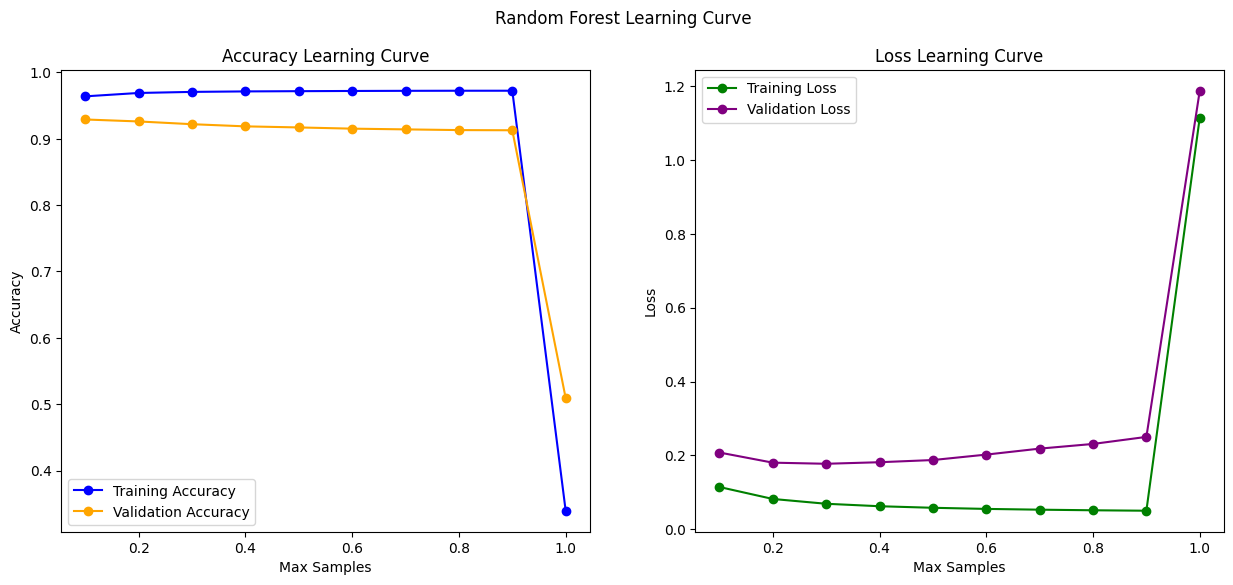

In [171]:
best_accuracy = 0
best_loss=100
maxs_list = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for maxs in param_grid['max_samples']:
    maxs_list.append(maxs)

    model = RandomForestClassifier(n_estimators=192, max_features=3, max_samples=maxs, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)

    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)

    print(f"{maxs} max samples, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{maxs} max samples, Train Accuracy: {train_loss}, Validation Accuracy: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_maxs = maxs

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_maxs = maxs

print(f"Best accuracy is: {best_accuracy} and max samples is {best_acc_maxs}")
print(f"Best loss is: {best_loss} and max samples is {best_loss_maxs}")
    
maxs_acc_df = pd.DataFrame({'Max Samples': maxs_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
maxs_loss_df = pd.DataFrame({'Max Samples': maxs_list,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.title('Accuracy Learning Curve')
plt.xlabel('Max Samples')
plt.ylabel('Accuracy')
plt.plot(maxs_acc_df['Max Samples'], maxs_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(maxs_acc_df['Max Samples'], maxs_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()


plt.subplot(122)
plt.title('Loss Learning Curve')
plt.xlabel('Max Samples')
plt.ylabel('Loss')
plt.plot(maxs_loss_df['Max Samples'], maxs_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(maxs_loss_df['Max Samples'], maxs_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()
 
plt.suptitle("Random Forest Learning Curve")
plt.show()

Max Depth

10 Max Depth, Train Accuracy: 0.8678195270368382, Validation Accuracy: 0.8017565646203408
10 Max Depth, Train Loss: 0.36286543042149927, Validation Loss: 0.4816295361994252
30 Max Depth, Train Accuracy: 0.9705807863358693, Validation Accuracy: 0.9221424329139896
30 Max Depth, Train Loss: 0.0689015438054499, Validation Loss: 0.16803443139152313
50 Max Depth, Train Accuracy: 0.9706010475023047, Validation Accuracy: 0.9219264618541115
50 Max Depth, Train Loss: 0.06883070903401248, Validation Loss: 0.1771598609006009
60 Max Depth, Train Accuracy: 0.9706010475023047, Validation Accuracy: 0.9219264618541115
60 Max Depth, Train Loss: 0.06883070903401248, Validation Loss: 0.1771598609006009
70 Max Depth, Train Accuracy: 0.9706010475023047, Validation Accuracy: 0.9219264618541115
70 Max Depth, Train Loss: 0.06883070903401248, Validation Loss: 0.1771598609006009
80 Max Depth, Train Accuracy: 0.9706010475023047, Validation Accuracy: 0.9219264618541115
80 Max Depth, Train Loss: 0.06883070903401248

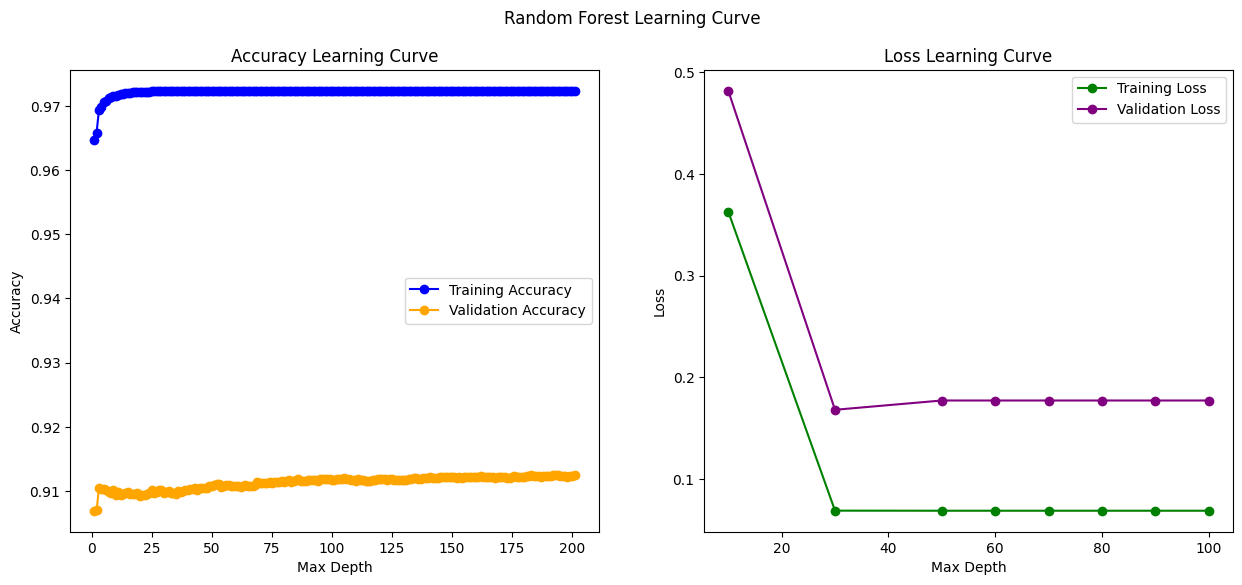

In [174]:
best_accuracy = 0
best_loss=100
depth_list = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for md in param_grid['max_depth']:
    depth_list.append(md)

    model = RandomForestClassifier(n_estimators=192, max_features=3, max_samples=0.3, max_depth=md, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)

    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)


    print(f"{md} Max Depth, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{md} Max Depth, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_md = md

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_md = md
    
depth_acc_df = pd.DataFrame({'Max Depth': depth_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
depth_loss_df = pd.DataFrame({'Max Depth': depth_list,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})



print(f"Best accuracy is: {best_accuracy} and estimators is {best_acc_md}")
print(f"Best loss is: {best_loss} and estimators is {best_loss_md}")

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.title('Accuracy Learning Curve')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()


plt.subplot(122)
plt.title('Loss Learning Curve')
plt.xlabel('Max Depth')
plt.ylabel('Loss')
plt.plot(depth_loss_df['Max Depth'], depth_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(depth_loss_df['Max Depth'], depth_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()
 
plt.suptitle("Random Forest Learning Curve")
plt.show()

#https://learnt.io/blog/how-to-plot-multiple-graphs-in-python/

10 Max Depth, Train Accuracy: 0.8678195270368382, Validation Accuracy: 0.8017565646203408
10 Max Depth, Train Loss: 0.36286543042149927, Validation Loss: 0.4816295361994252
11 Max Depth, Train Accuracy: 0.891315726379701, Validation Accuracy: 0.8365639004373414
11 Max Depth, Train Loss: 0.3092116677034381, Validation Loss: 0.4217904834347744
12 Max Depth, Train Accuracy: 0.9098614473901929, Validation Accuracy: 0.8630923456256862
12 Max Depth, Train Loss: 0.2649668443038358, Validation Loss: 0.36939660423574733
13 Max Depth, Train Accuracy: 0.9280728591545016, Validation Accuracy: 0.8877670392167449
13 Max Depth, Train Loss: 0.22636212782990164, Validation Loss: 0.3219054863251123
14 Max Depth, Train Accuracy: 0.9417660308037267, Validation Accuracy: 0.9076003815488725
14 Max Depth, Train Loss: 0.19116697905441288, Validation Loss: 0.2789906838744976
15 Max Depth, Train Accuracy: 0.9514913906926955, Validation Accuracy: 0.9205766427298742
15 Max Depth, Train Loss: 0.16338868247376667, 

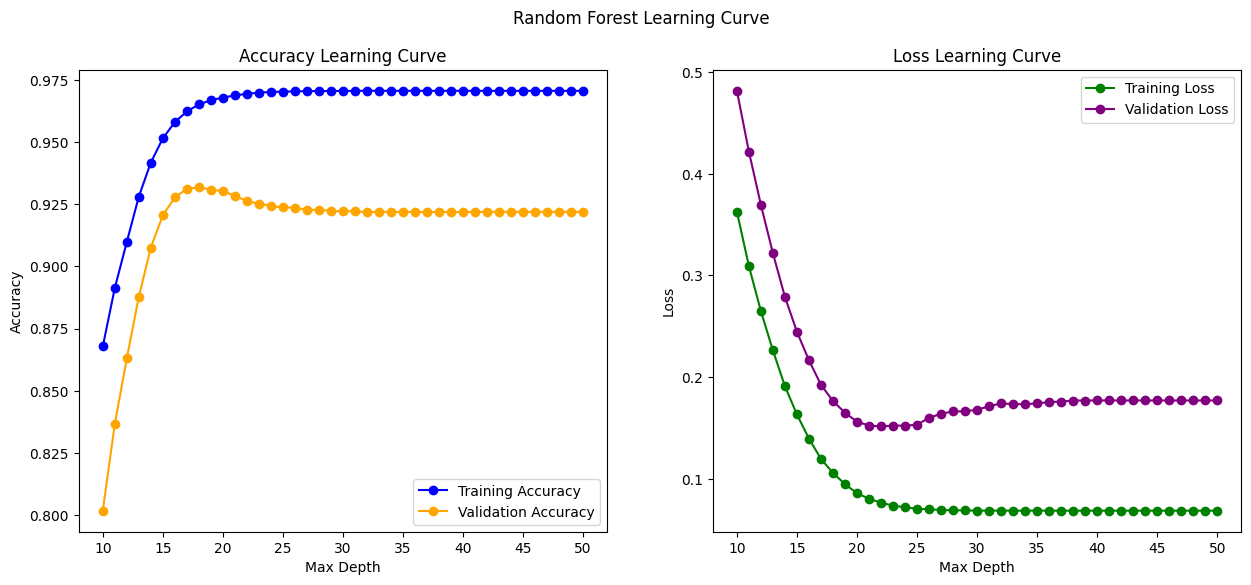

In [175]:
best_accuracy = 0
best_loss=100
depth_list = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for md in range(10, 51):
    depth_list.append(md)

    model = RandomForestClassifier(n_estimators=192, max_features=3, max_samples=0.3, max_depth=md, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)

    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)


    print(f"{md} Max Depth, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{md} Max Depth, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_md = md

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_md = md
    
depth_acc_df = pd.DataFrame({'Max Depth': depth_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
depth_loss_df = pd.DataFrame({'Max Depth': depth_list,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})


print(f"Best accuracy is: {best_accuracy} and estimators is {best_acc_md}")
print(f"Best loss is: {best_loss} and estimators is {best_loss_md}")

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.title('Accuracy Learning Curve')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(depth_acc_df['Max Depth'], depth_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(depth_acc_df['Max Depth'], depth_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()


plt.subplot(122)
plt.title('Loss Learning Curve')
plt.xlabel('Max Depth')
plt.ylabel('Loss')
plt.plot(depth_loss_df['Max Depth'], depth_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(depth_loss_df['Max Depth'], depth_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()
 
plt.suptitle("Random Forest Learning Curve")
plt.show()

In [184]:
model = RandomForestClassifier(n_estimators=192, max_features=3, max_samples=0.3, max_depth=18, n_jobs=-1, random_state=7, criterion='log_loss')
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}')

Training Accuracy: 0.9642593024080396, Validation Accuracy: 0.9336608894408149, Test Accuracy: 0.9281189259232596


In [181]:
model = RandomForestClassifier(n_estimators=192, max_features=3, max_samples=0.3, max_depth=18, n_jobs=-1, random_state=7)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}')

Training Accuracy: 0.9651170251204695, Validation Accuracy: 0.9317711426668827, Test Accuracy: 0.9271830681736376


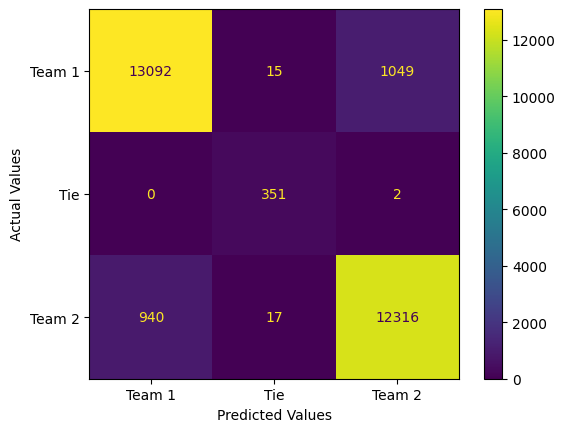

              precision    recall  f1-score   support

      Team 1       0.93      0.92      0.93     14156
         Tie       0.92      0.99      0.95       353
      Team 2       0.92      0.93      0.92     13273

    accuracy                           0.93     27782
   macro avg       0.92      0.95      0.94     27782
weighted avg       0.93      0.93      0.93     27782



In [177]:
labels = ['Team 1', 'Tie', 'Team 2']
cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_test, y_test_pred, target_names=labels))

In [187]:
y_test_pred_list  = []
for y in y_test_pred:
    if y==0:
        y_test_pred_list.append("Team 1")
    elif y == 2:
        y_test_pred_list.append("Team 2")
    elif y==1:
        y_test_pred_list.append("Tie")

In [188]:
y_test_pred_df = pd.DataFrame(y_test_pred_list, columns=["Winner Bat First"])

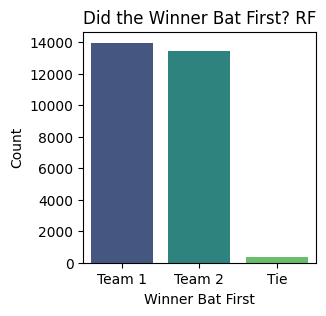

In [189]:
plt.figure(figsize=(3, 3))
sns.countplot(x='Winner Bat First', data=y_test_pred_df, palette='viridis')

# Adding labels and title
plt.ylabel('Count')
plt.title('Did the Winner Bat First? RF')
plt.show()

In [190]:
y_test_pred_df.value_counts(normalize=True)

Winner Bat First
Team 1              0.502664
Team 2              0.483586
Tie                 0.013750
Name: proportion, dtype: float64

Mine shows less bias towards the second batting team

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Improved recall significantly, so it's now overpredicting that things are a tie, but that's preferable to incorrectly predicting one of the other two classes.  Also reduced the overfitting.

In [ ]:
#REMEMBER TO CHANGE TERMINAL NODES TO LEAF NODES IN THE PARAM GRIDS

https://github.com/ngoix/scikit-learn/commit/2661da0d3578eda406dcf1867443d9f744165c5f

Use the tuned hyperparameters for a new RF

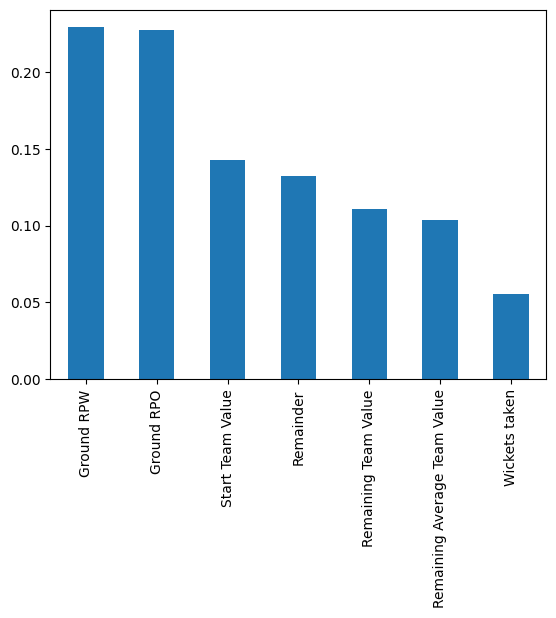

In [191]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Challenge with feature selection is that the question here is whether the run rate of the ground, team value and remainder improve the performance rate of wickets taken and remaining overs and balls.

https://www.datacamp.com/tutorial/random-forests-classifier-python

max_features: 48595930.13256911
n_estimators: 48495444.12346617
max_samples: 23721216.877849072
max_depth: 1112432.6407072397
